# Dependencies

In [1]:
from PIL import Image, ImageOps
import pylab
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from random import randint

from scipy import signal
from sklearn.decomposition import FastICA
from sklearn.feature_extraction import image
from ipywidgets import interact, interactive, fixed
%matplotlib inline

# Utility Functions

In [2]:
def generate_gabor(size, shift, sigma, rotation, phase_shift, frequency):
    radius = (int((size[0]/2.0)), int((size[1]/2.0)))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    x = x - int(shift[0])
    y = y - int(shift[1])
    x = x * frequency
    y = y * frequency
    tmp = x * np.cos(rotation) + y * np.sin(rotation) + phase_shift
    radius = (int(size[0]/2.0), int(size[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    
    x = x - int(shift[0])
    y = y - int(shift[1])
    x1 = x * np.cos(rotation) + y * np.sin(rotation)
    y1 = -x * np.sin(rotation) + y * np.cos(rotation)
    
    sinusoid = np.cos(tmp)
    
    gauss = np.e * np.exp(np.negative(0.5 * ((x1**2 / sigma[0]**2) + (y1**2 / sigma[1]**2)))) 
    gauss = gauss / 2*np.pi * sigma[0] * sigma[1]
    
    gabor = gauss * sinusoid
    return gabor

def open_norm(path,verbose=False):
    raw = np.array(Image.open(path).convert("L"))
    norm = (raw - np.mean(raw)) / np.std(raw)
    
    if verbose:
        return raw, norm
    else:
        return norm
    
def linear_convolution(center, slide): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    #plt.imshow(padded_slide,origin="lower")
    #plt.show()
    estimate = np.zeros([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    #plt.plot(estimate)
    #plt.show()
    return np.abs(estimate)
    
def double_convolve(normal, shifted, image, pupillary_distance):
    
    normal_convolved = signal.convolve2d(image, normal, boundary='symm', mode='same')
    shifted_convolved = signal.convolve2d(image, shifted, boundary='symm', mode='same')
    
    return_shape = image.shape
    
    realigned = np.zeros(return_shape)

    


    normal_convolved = normal_convolved[0:,0:-pupillary_distance]
    shifted_convolved = shifted_convolved[0:,pupillary_distance:]
    

    
    
    diff = np.subtract(normal_convolved, shifted_convolved)
    mul = normal_convolved * shifted_convolved
    #plt.imshow(mul,cmap="nipy_spectral")
    #plt.show()
    
    #REMOVE BELOW COMMENTS TO THRESH SUBHALF VALUES
    #low_values_flags = mul <= 0 #mul.max()*0.5  # Where values are low
    #mul[low_values_flags] = 0  # All low values set to 0
    realigned[0:,pupillary_distance:] = mul
    return np.abs(realigned)

def scale_disparity(activity_map, disparity_map):
    scaled_disparity = np.zeros([activity_map.shape[0],activity_map.shape[1],disparity_map.shape[0]])
    scaled_disparity[:,:] = disparity_map
    for x in range(activity_map.shape[0]):
        for y in range(activity_map.shape[1]):
            scaled_disparity[x,y] = activity_map[x,y] * scaled_disparity[x,y]
            
    return scaled_disparity

# LGN Model

In [3]:
import random
def distance(x0, y0, x1, y1):
  return np.sqrt(pow(x0-x1,2) + pow(y0-y1,2))

class LGN: 
  """
  this class defines a model which generates binocular spontaneous activity
  """
  
  def __init__(self, width = 128, p = 0.5, r = 1.0, t = 1, trans = 0.0,
    make_wave = True, num_layers=2, random_seed=0):
    random.seed(random_seed)
    self.width = width
    self.p = p
    self.r = r
    self.t = t
    self.trans = trans
    self.num_layers = num_layers
    if make_wave:
      self.reset_wave()

  def reset_wave(self):
    """ create another random wave """
    # setting up the network
    w = self.width
    self.recruitable = np.random.rand(self.num_layers, w, w) < self.p
    self.tot_recruitable = len(np.where(self.recruitable)[0])
    self.tot_recruitable_active = 0
    self.tot_active = 0
    self.active = np.zeros([self.num_layers,w,w],bool)
    self.active_neighbors = np.zeros([self.num_layers,w,w],int)
    self.activated = []; # the recently active nodes
    
    if self.tot_recruitable > 0:
      while self.fraction_active() < 0.2:
        self.activate()  

  def fraction_active(self):
    """ returns the fraction of potentially recruitable cells which are active """
    if self.tot_recruitable > 0:
      return float(self.tot_recruitable_active) / self.tot_recruitable
    else:
      return nan

  def propagate(self):
    """ propagate the activity if a valid node has been activated """
    # activated only has recruitable and currently inactive members
    while len(self.activated) > 0:
      act_l, act_x, act_y = self.activated.pop()
      self.active[act_l,act_x,act_y] = True
      self.tot_active += 1
      self.tot_recruitable_active += 1
      for l in range(self.num_layers):
        for x in range(int(act_x-self.r),int(act_x+self.r+1)):
          for y in range(int(act_y-self.r),int(act_y+self.r+1)):
            if distance(act_x,act_y,x,y) <= self.r:
              xi = x % self.width
              yi = y % self.width
              if l != act_l: # spread the activity across layers
                if np.random.rand() < self.trans: # transfer the activity
                  self.active_neighbors[l, xi,yi] += 1
              else: # if it is the same layer
                self.active_neighbors[l, xi,yi] += 1
              if self.active_neighbors[l, xi,yi] == self.t and \
                not self.active[l, xi,yi]:
                if self.recruitable[l, xi,yi]:
                  self.activated.append([l, xi,yi])
                else: # activate the node but don't propagate the activity
                  self.active[l,xi,yi] = True
                  self.tot_active += 1

  def activate(self):
    """ activate a random potentially active node """
    if self.fraction_active() > 0.95:
      return
      
    # pick a random point
    while True:
      l = np.random.randint(0,self.num_layers)
      x = np.random.randint(0,self.width)
      y = np. random.randint(0,self.width)
      if (self.recruitable[l,x,y] and not self.active[l,x,y]):
        break
    self.activated.append([l,x,y])
    self.propagate()

  def correlation(self):
    """ returns the correlation between the left and right images """
    # the total number of activations in common
    # same_count = len(where(self.active[0,:,:] == self.active[1,:,:])[0])
    # return float(same_count) / (self.width * self.width)
    
    # create an activity matrix of 0's and 1's (instead of True and False)
    if self.num_layers < 2:
      print("monocular models cannot have correlations between eye layers")
      return 0
    w = self.width
    active01 = np.zeros([2,w,w],int)
    active01[where(self.active)] = 1
    
    mean0 = active01[0,:,:].mean()
    mean1 = active01[1,:,:].mean()
    std0 = active01[0,:,:].std()
    std1 = active01[1,:,:].std()
    cov = ((active01[0,:,:] - mean0) * (active01[1,:,:] - mean1)).mean()
    return cov / (std0 * std1)
    
  def make_img_mat(self, show_img=True):
    """ return a matrix of 1's and 0's showing the activity in both layers """
    img_array = np.zeros([self.num_layers,self.width,self.width])
    border_width = 10 if self.num_layers > 1 else 0
    w = self.width
    for l in range(self.num_layers):
        img = np.zeros([w, w], float)
        for x in range(0,w-1):
            for y in range(0,w-1):
                if self.active[l,x,y]:
                    img[x,y] = 1           
    
        img_array[l] = img         
        #plt.imshow(img)
        #plt.show()
        
    return img_array

In [4]:
def runEx(pShift=0.0):
    
    tarray = []
    parray = []
    carray = []
    harray = []
    
    for bigT in range(1,9):
        bigP = bigT / (((np.pi * (3**2)/2))*1.1) + pShift
        print("t: ", bigT)
        print("p: ", bigP)

        feg = []
        seg = []

        for gg in range(10):


            patches_1 = []
            patches_2 = []
            for n in range(10):
                seed = randint(1,100)
                # Generate the spontaneous activity patterns
                L = LGN(width = 128, p = 0.24, r = 3, t = 4, trans = 0.1, make_wave = True, num_layers=2, random_seed=seed)
                # Save patterns as images
                images = L.make_img_mat()

                # Generate 16x16 image patches for both left and right eye using a sliding window
                patches_1.append(image.extract_patches_2d(images[0], (16, 16)))
                patches_2.append(image.extract_patches_2d(images[1], (16, 16)))

            patches_1 = np.array(patches_1)
            patches_2 = np.array(patches_2)

            blacklist = []

            for x in range(0,patches_1.shape[0]):
                if patches_1[x].std() == 0.0:
                    blacklist.append(x)
                    continue
                        #add to black list

                if patches_2[x].std() == 0.0:
                    blacklist.append(x)
                    #add to black list

            blacklist = np.array(blacklist)
            if (blacklist.shape[0] != 0):
                patches_1 = np.delete(patches_1, blacklist, axis=0)
                patches_2 = np.delete(patches_2, blacklist, axis=0)
                    #removes boring patches (the patches with no activity!)

            patches_1 = patches_1.reshape((patches_1.shape[0]*patches_1.shape[1]),16,16)
            patches_2 = patches_2.reshape((patches_2.shape[0]*patches_2.shape[1]),16,16)

            # Reshape the array to the shape (patches, the size of the patches)
            reshaped_patches_1 = patches_1.reshape(-1, patches_1.shape[1]*patches_1.shape[1])
            reshaped_patches_2 = patches_2.reshape(-1, patches_2.shape[1]*patches_2.shape[1])
            composite_patches = np.concatenate((reshaped_patches_1,reshaped_patches_2),axis=1)

            # Number of components to create/use
            n_ica_components = 50

            # Run ICA on all the patches and return generated components
            icatemp = FastICA(n_components=n_ica_components, random_state=1) # note, sensitive to n_components
            icafit_1 = icatemp.fit(composite_patches)
            ica_comp_1 = icafit_1.components_

            # Get the components from both eye layers
            first_eye = ica_comp_1[:, 0:patches_1.shape[1]**2]
            second_eye = ica_comp_1[:, patches_1.shape[1]**2:]

            # Reshape components (for easier plotting)
            results_1 = first_eye.reshape(-1,patches_1.shape[1],patches_1.shape[1])
            results_2 = second_eye.reshape(-1,patches_1.shape[1],patches_1.shape[1])
            feg.append(results_1)
            seg.append(results_2)



        feg = np.array(feg)
        seg = np.array(seg)
        first_eye_gabors = np.array(feg).reshape((feg.shape[0] * feg.shape[1]),16,16)
        second_eye_gabors = np.array(seg).reshape((seg.shape[0] * seg.shape[1]),16,16)
        auto = open_norm("shift5_70patch.png",verbose=False)

        initi = True

        for x in range(0,first_eye_gabors.shape[0]):
            am1 = double_convolve(first_eye_gabors[x], second_eye_gabors[x], auto,70)
            dm1 = linear_convolution(first_eye_gabors[x], second_eye_gabors[x])
            if ((np.argmax(np.abs(dm1))-16) != 0):
                sd1 = scale_disparity(am1,dm1)
                if initi == True:
                    ca = sd1
                    initi = False
                else:
                    ca = ca + sd1



        depth_estimate = np.zeros([ca.shape[0],ca.shape[1]])

        for x in range(ca.shape[0]):
            for y in range(ca.shape[1]):
                peak = np.abs(np.argmax(np.abs(ca[x,y]))-16)
                depth_estimate[x,y] = peak




        dm = np.array(Image.open("dm.png").convert("L"))
        corr = np.corrcoef(depth_estimate[0:600,70:670].flatten(),dm[0:600,70:670].flatten())[0,1]
        print("corr: ", corr)
        


        hasher = "%f%f%f" % (bigT, bigP, corr)
        hasher = hashlib.sha256(hasher.encode('utf-8')).hexdigest()
        hasher = hasher[:20]
        print("hash: ", hasher)
        namer = "lgn_corr_data/%s.png" % (hasher)

        plt.imshow(depth_estimate[0:600,70:670], cmap="binary")
        plt.show()

        
        saver = depth_estimate[0:600,70:670]
        
        act = (255.0 / saver.max() * (saver - saver.min())).astype(np.uint8)
        sv = Image.fromarray(act)
        sv = ImageOps.colorize(sv, (0,0,0), (0,255,0))
        sv.save(namer)
        
        tarray.append(bigT)
        parray.append(bigP)
        carray.append(corr)
        harray.append(hasher)

        
    return {"t": tarray, "p": parray, "c": carray, "h": harray}


t:  1
p:  0.0643050275118769
corr:  0.227152487218
hash:  2be4e854a3a8019f10ce


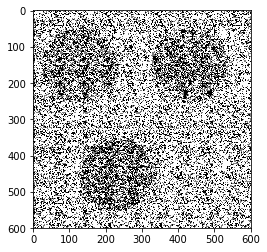

t:  2
p:  0.1286100550237538
corr:  0.117489233873
hash:  d7a4863ed4d821dd12da


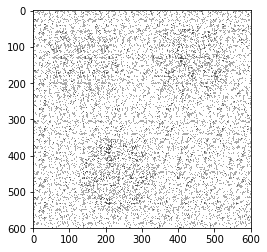

t:  3
p:  0.1929150825356307
corr:  0.168143650753
hash:  7574c16b165310f308f6


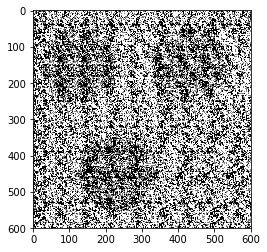

t:  4
p:  0.2572201100475076
corr:  0.118918391588
hash:  a29c1089edfd07b87cc4


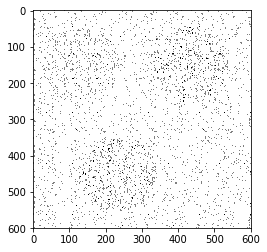

t:  5
p:  0.3215251375593845
corr:  0.229245570069
hash:  d1cfe3053f6e64b2ae1f


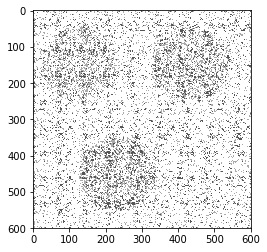

t:  6
p:  0.3858301650712614
corr:  0.202191439014
hash:  c7cee8860f2a854d4979


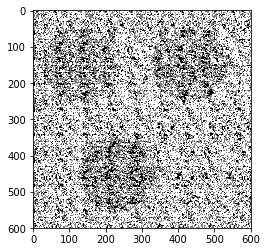

t:  7
p:  0.45013519258313833
corr:  0.17564410009
hash:  75012fbdb92846eac602


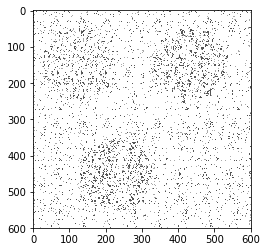

t:  8
p:  0.5144402200950152
corr:  0.115912080481
hash:  054c4c7786a59a03ffc3


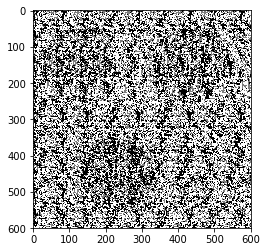

In [5]:
test = runEx()


In [6]:
print(test)
t = [1, 2, 3, 4, 5, 6, 7, 8]
p = [0.0643050275118769, 0.1286100550237538, 0.1929150825356307, 0.2572201100475076, 0.3215251375593845, 0.3858301650712614, 0.45013519258313833, 0.5144402200950152]
c = [0.2271524872176735, 0.11748923387279109, 0.16814365075272392, 0.11891839158822315, 0.22924557006867541, 0.2021914390136689, 0.17564410008960482, 0.11591208048129203]
h = ['2be4e854a3a8019f10ce', 'd7a4863ed4d821dd12da', '7574c16b165310f308f6', 'a29c1089edfd07b87cc4', 'd1cfe3053f6e64b2ae1f', 'c7cee8860f2a854d4979', '75012fbdb92846eac602', '054c4c7786a59a03ffc3']

{'t': [1, 2, 3, 4, 5, 6, 7, 8], 'p': [0.0643050275118769, 0.1286100550237538, 0.1929150825356307, 0.2572201100475076, 0.3215251375593845, 0.3858301650712614, 0.45013519258313833, 0.5144402200950152], 'c': [0.2271524872176735, 0.11748923387279109, 0.16814365075272392, 0.11891839158822315, 0.22924557006867541, 0.2021914390136689, 0.17564410008960482, 0.11591208048129203], 'h': ['2be4e854a3a8019f10ce', 'd7a4863ed4d821dd12da', '7574c16b165310f308f6', 'a29c1089edfd07b87cc4', 'd1cfe3053f6e64b2ae1f', 'c7cee8860f2a854d4979', '75012fbdb92846eac602', '054c4c7786a59a03ffc3']}


In [ ]:
plusp1 = runEx(0.1)
plusp2 = runEx(0.2)

minusp1 = runEx(-0.1)
minusp2 = runEx(-0.2)

t:  1
p:  0.16430502751187692


In [ ]:
'''

This cell intentionally left blank

































































'''

In [ ]:
feg = np.array(feg)
seg = np.array(seg)
first_eye_gabors = np.array(feg).reshape((feg.shape[0] * feg.shape[1]),16,16)
second_eye_gabors = np.array(seg).reshape((seg.shape[0] * seg.shape[1]),16,16)



plt.imshow(first_eye_gabors[499])
plt.show()


In [ ]:
sv = PIL.ImageOps.colorize(sv, (0,0,0), (0,255,0))


In [ ]:
plt.imshow(first_eye_gabors[0])
plt.show()

print(first_eye_gabors[0].shape)

auto = open_norm("shift5_70patch.png",verbose=False)

initi = True

for x in range(0,first_eye_gabors.shape[0]):
    am1 = double_convolve(first_eye_gabors[x], second_eye_gabors[x], auto,70)
    dm1 = linear_convolution(first_eye_gabors[x], second_eye_gabors[x])
    if ((np.argmax(np.abs(dm1))-16) != 0):
        sd1 = scale_disparity(am1,dm1)
        if initi == True:
            ca = sd1
            initi = False
        else:
            ca = ca + sd1
        


depth_estimate = np.zeros([ca.shape[0],ca.shape[1]])

for x in range(ca.shape[0]):
    for y in range(ca.shape[1]):
        peak = np.abs(np.argmax(np.abs(ca[x,y]))-16)
        depth_estimate[x,y] = peak
        
        
plt.imshow(depth_estimate[0:600,70:670], cmap="binary")
plt.show()
dm = np.array(PIL.Image.open("dm.png").convert("L"))
corr = np.corrcoef(depth_estimate[0:600,70:670].flatten(),dm[0:600,70:670].flatten())[0,1]
print(corr)


In [ ]:

        
        
plt.imshow(depth_estimate[0:600,70:670])
plt.savefig('foo.png', dpi = 300)
plt.show()





In [ ]:
am1 = double_convolve(first_eye_gabors[3], second_eye_gabors[3], auto,70)
plt.imshow(am1)
plt.show()

In [ ]:
for bigT in range(1,9):
    bigP = bigT / (((np.pi * (3**2)/2))*1.1)
    print(bigP)